# Relevant Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm.notebook import tqdm, trange
import autograd.numpy as np
import autograd.scipy.stats as stats
import scipy.optimize as optimize
from autograd.scipy.linalg import logm
from autograd import grad, jacobian, hessian
import numpy
import scipy
import pandas as pd
import ipywidgets as widgets
import time
from sklearn import linear_model

# Week 1

In [106]:
# Generate datapoints
l = 20
dim = 1
d = np.random.rand(l, dim) * 20
noise = 1000 # sigma^2_y
def augment_d(d): # Augments dataset with an intercept column
    return np.concatenate((d.T, [np.ones(len(d))]), axis=0).T
eps = np.random.randn(l) * np.sqrt(noise)

true_weights = np.array([-9, 15]) # Underlying data-generating weights
y = augment_d(d) @ true_weights + eps

In [70]:
mu_prior = np.array([19, 5])
cov_prior = np.array([[20, 0.3], [0.3, -3]]) * 20

def analytical_posterior_pdf(theta, d, y): # Compute pdf
    mu = mu_prior + cov_prior @ d.T @ np.linalg.inv(d @ cov_prior @ d.T + noise * np.eye(l)) @ (y - d @ mu_prior)
    cov = cov_prior - cov_prior @ d.T @ np.linalg.inv(d @ cov_prior @ d.T + noise * np.eye(l)) @ d @ cov_prior
    return stats.multivariate_normal.pdf(theta, mean=mu, cov=cov)
def analytical_posterior_params(d, y, mu_prior=mu_prior, cov_prior=cov_prior): # Get parameters of pdf
    mu = mu_prior + cov_prior @ d.T @ np.linalg.inv(d @ cov_prior @ d.T + noise * np.eye(l)) @ (y - d @ mu_prior)
    cov = cov_prior - cov_prior @ d.T @ np.linalg.inv(d @ cov_prior @ d.T + noise * np.eye(l)) @ d @ cov_prior
    return mu, cov
stats.multivariate_normal.pdf(theta, mean=mu, cov=cov)

In [71]:
true_weights

array([-9, 15])

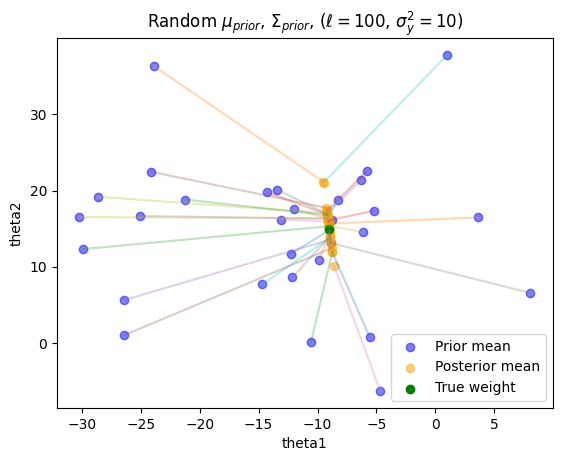

In [72]:
N = 30
mu_prior_samples = (np.random.randn(N, 2))*10 + true_weights
cov_prior_samples = np.tile(np.eye(2), (N, 1, 1))
mus = np.array([analytical_posterior_params(augment_d(d), y, mu_prior=mu_prior, cov_prior=cov_prior)[0] for mu_prior, cov_prior in zip(mu_prior_samples, cov_prior_samples)])

#plt.scatter([(eigen[0], eigen[1]) for eigen in np.linalg.eigen(covs)])
for prior, posterior in zip(mu_prior_samples, mus):
    plt.plot([prior[0], posterior[0]], [prior[1], posterior[1]], alpha=0.3)
plt.scatter(mu_prior_samples[:, 0], mu_prior_samples[:, 1], color="blue", label="Prior mean", alpha=0.5)
plt.scatter(mus[:, 0], mus[:, 1], color="orange", label="Posterior mean", alpha=0.5)
plt.scatter(true_weights[0], true_weights[1], color="green", label="True weight")
#plt.xlim(-40, 10)
#plt.ylim(-10,40)
plt.xlabel("theta1")
plt.ylabel("theta2")
plt.title("Random $\mu_{prior}$, $\Sigma_{prior}$, ($\ell = %d$, $\sigma^2_y = %d$)" % (l, noise))
plt.legend()

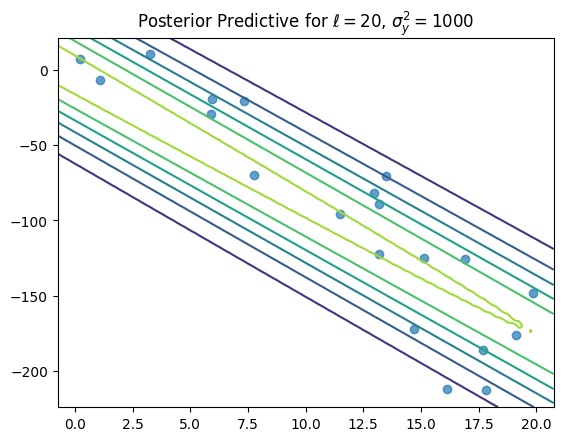

In [107]:
def plot_predictive(mean, cov, x, y):
    # Define the grid for the contour plot
    plt.scatter(x, y, alpha=0.7)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    x_grid, y_grid = numpy.mgrid[xmin:xmax:.5, ymin:ymax:.5]

    pos = np.empty(x_grid.shape + (2,))
    pos[:, :, 0] = x_grid
    pos[:, :, 1] = y_grid
    #print(np.dstack((x_grid, y_grid)))
    z = []

    # Create a multivariate normal distribution
    for row in np.dstack((x_grid, y_grid)):
        row_x = augment_d(np.array([row[:, 0]]).T)
        row_y = np.array([row[:, 1]])
        #row_z = scipy.stats.multivariate_normal.pdf(row_y, row_x @ mean, np.var(y)*np.eye(len(row_x)) + row_x @ cov @ row_x.T)
        #print(row_z)
        row_z = []
        for [x_p, y_p] in row:
            #p = np.array([x_var, y_var])
            x_p = np.array([x_p, 1])
            rv = scipy.stats.multivariate_normal(x_p.T @ mean, noise + x_p.T @ cov @ x_p)
            # Evaluate the probability density function on the grid
            row_z.append(rv.pdf(y_p))
        z.append(np.array(row_z))
    z = np.array(z).reshape(x_grid.shape)
    # Plot the scatter plot
    plt.contour(x_grid, y_grid, z)
    ones = np.ones((len(np.linspace(xmin, xmax)), 1))
    x_aug = np.concatenate((np.linspace(xmin, xmax).reshape(len(ones), 1), ones), axis=1)
    #plt.plot(np.linspace(xmin, xmax).reshape(len(ones), 1), f(x_aug, mean), c='purple', label="Mean Parameter Estimate")
    #plt.legend()
    plt.title("Posterior Predictive for $\ell = %d$, $\sigma^2_y = %d$" % (l, noise))
    plt.show()
params = analytical_posterior_params(augment_d(d), y)
plot_predictive(params[0], params[1], d, y)